In [1]:
%matplotlib inline
import numpy as np
import agents as ag
import matplotlib.pyplot as plt

In [2]:
# function to distribute tasks evenly to agents so as to ensure non-overlapping requirement
def split_tasks(num_tasks, num_workers, tasks_per_worker, tasks):
    # for simplicity make sure numbers divide properly
    # and num_tasks/tasks_per_worker = workers/workers_per_task
    if num_tasks % tasks_per_worker != 0:
        raise ValueError("Invalid tasks_per_worker, must divide num_tasks evenly.")
    
    rate = num_tasks/tasks_per_worker
    workers_per_task = num_workers/rate
    
    if workers_per_task*rate != num_workers:
        raise ValueError("Invalid num_workers, must be divisible by num_tasks/tasks_per_worker.")
        
    if workers_per_task <= 1:
        raise ValueError("Workers per task <= 1, not suitable for this mechanism.")
    
    # return dictionary assigning agent to list of tasks
    task_assignments = {}
    for i in range(rate):
        task_assignments[i] = get_tasks(np.arange(tasks_per_worker*i, tasks_per_worker*(i+1)), tasks)
    
    for agent_block in range(1, workers_per_task):
        for idx in range(rate):
            task_assignments[agent_block*rate + idx] = get_tasks(np.arange(idx, idx+rate*(tasks_per_worker), rate), tasks)
    
    return task_assignments

# given tasks get subset of dictionary of tasks
def get_tasks(assignments, tasks):
    return dict(map(lambda x: (x, tasks[x]), assignments))

In [3]:
# setup
N = 100
num_agents = 20
tasks = dict(zip(range(N), np.random.uniform(size=N)>0.5))
task_assignments = split_tasks(N, num_agents, 10, tasks)
num_nonoverlapping = 5

In [4]:
def simulate_rewards(agents, num_nonoverlapping, task_assignments, trials, title):
    rewards = []
    for i in range(trials):
        for idx, agent in enumerate(agents):
            agent.reset(task_assignments[idx])
        for agent in agents:
            for idx in agent.tasks:
                #find reference rater who did the same task
                refidx = 0
                while refidx < len(agents) and (idx not in agents[refidx].tasks or agents[refidx] == agent):
                    refidx += 1
                agent.task_score(idx, agents[refidx], num_nonoverlapping)
        rewards.append(agents[0].reward)
    plt.hist(rewards)
    plt.axvline(x=np.mean(rewards), ymin=0, ymax=trials, color='r', linewidth=2)
    plt.title(title)
    plt.xlabel("Reward")
    plt.ylabel("Trials")

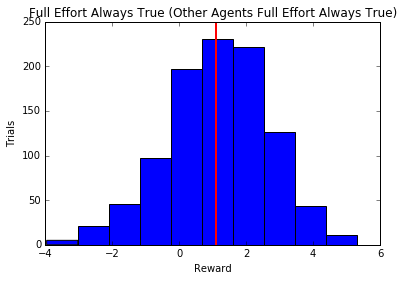

In [5]:
# all truth/full effort agents, run 1000 times and plot reward of first agent
agents = [ag.FullEffortTrueAgent(task_assignments[i]) for i in range(num_agents)]
simulate_rewards(agents, num_nonoverlapping, task_assignments, 1000, "Full Effort Always True (Other Agents Full Effort Always True)")

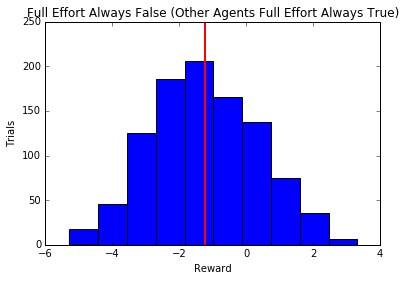

In [6]:
# 1 false/full effort agent, rest truth/full effort agents, run 1000 times and plot reward of false agent
agents = [ag.FullEffortFalseAgent(task_assignments[0])] + [ag.FullEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)]
simulate_rewards(agents, num_nonoverlapping, task_assignments, 1000, "Full Effort Always False (Other Agents Full Effort Always True)")

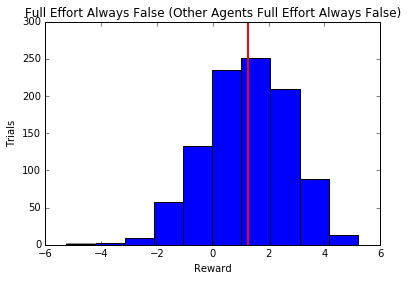

In [7]:
# all false/full effort agents, run 1000 times and plot reward of first agent
agents = [ag.FullEffortFalseAgent(task_assignments[i]) for i in range(num_agents)]
simulate_rewards(agents, num_nonoverlapping, task_assignments, 1000, "Full Effort Always False (Other Agents Full Effort Always False)")

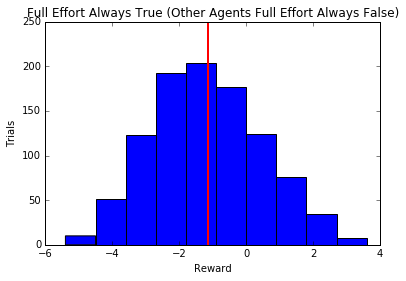

In [8]:
# 1 true/full effort agent, rest false/full effort agents, run 1000 times and plot reward of true agent
agents = [ag.FullEffortTrueAgent(task_assignments[0])] + [ag.FullEffortFalseAgent(task_assignments[i+1]) for i in range(num_agents-1)]
simulate_rewards(agents, num_nonoverlapping, task_assignments, 1000, "Full Effort Always True (Other Agents Full Effort Always False)")

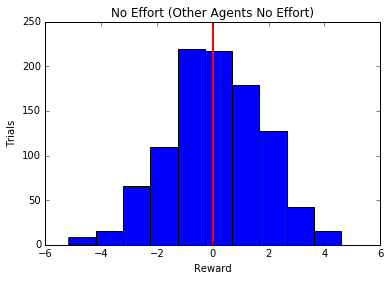

In [9]:
# all no effort agents
agents = [ag.NoEffortAgent(task_assignments[i]) for i in range(num_agents)]
simulate_rewards(agents, num_nonoverlapping, task_assignments, 1000, "No Effort (Other Agents No Effort)")